
# Indoor Localization with GANs - Etapa 2
Este notebook implementa a Etapa 2 do artigo **Indoor Localization Using Data Augmentation via Selective GANs**, com foco na criação, treinamento e avaliação de um modelo GAN para gerar vetores RSSI sintéticos.

---


In [30]:
## 1. Imports e Configurações Iniciais
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [31]:
## 2. Dados Reais Simulados (RSSI)
# Definir parâmetros do ambiente
area_size = 20
n_aps = 10
n_positions = 100
n_measurements = 10

pt = 20
pl0 = 40
frequency = 2.4e9
mu = 3.5
sigma = 2
d0 = 1

np.random.seed(42)
ap_positions = np.random.uniform(0, area_size, size=(n_aps, 2))
positions = np.random.uniform(0, area_size, size=(n_positions, 2))

def calculate_rssi(pos, ap_pos):
    d = np.linalg.norm(pos - ap_pos)
    if d < 1e-3:
        d = d0
    pl = pl0 + 20 * np.log10(frequency) + 10 * mu * np.log10(d / d0)
    shadowing = np.random.normal(0, sigma)
    return pt - pl + shadowing

real_rssi_data = []
for pos in positions:
    for _ in range(n_measurements):
        rssi_vector = [calculate_rssi(pos, ap) for ap in ap_positions]
        real_rssi_data.append(rssi_vector)

real_rssi_data = np.array(real_rssi_data)

# Normalização
scaler = MinMaxScaler(feature_range=(-1, 1))
real_rssi_data = scaler.fit_transform(real_rssi_data)

In [32]:
## 3. Construção do GAN
def build_generator(input_dim=10, output_dim=10):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_dim))
    model.add(Dense(output_dim, activation='tanh'))
    return model

def build_discriminator(input_dim=10):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [33]:
## 4. Treinamento do GAN
# Hiperparâmetros
epochs = 200
batch_size = 64
lr = 0.01
noise_dim = 10

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

discriminator.trainable = False
z = Input(shape=(noise_dim,))
fake = generator(z)
validity = discriminator(fake)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr))

losses = {'d': [], 'g': []}
real_labels = np.ones((batch_size, 1)) * 0.9
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    idx = np.random.randint(0, real_rssi_data.shape[0], batch_size)
    real_data = real_rssi_data[idx]

    noise = np.random.uniform(-1, 1, (batch_size, noise_dim))
    generated_data = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.uniform(-1, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    losses['d'].append(d_loss[0])
    losses['g'].append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.6379690766334534, G Loss: 0.662277340888977
Epoch 20, D Loss: 0.8940606713294983, G Loss: 0.47518694400787354
Epoch 40, D Loss: 1.0732672214508057, G Loss: 0.40888145565986633
Epoch 60, D Loss: 1.1734123229980469, G Loss: 0.38220152258872986
Epoch 80, D Loss: 1.2336077690124512, G Loss: 0.3684045672416687
Epoch 100, D Loss: 1.2717527151107788, G Loss: 0.3599987328052521
Epoch 120, D Loss: 1.2997331619262695, G Loss: 0.35432854294776917
Epoch 140, D Loss: 1.3213832378387451, G Loss: 0.35024571418762207
Epoch 160, D Loss: 1.3379766941070557, G Loss: 0.34716781973838806
Epoch 180, D Loss: 1.3515260219573975, G Loss: 0.34476232528686523


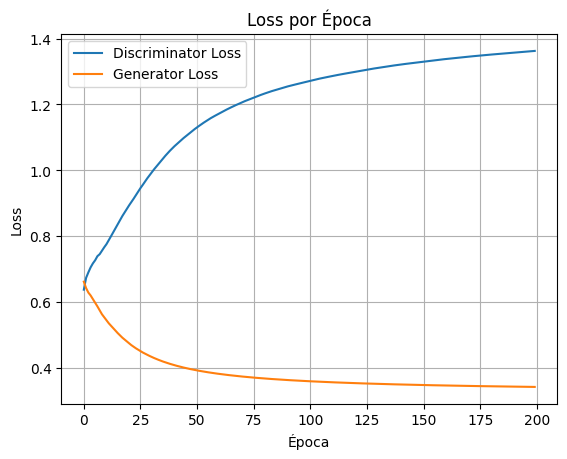

In [34]:

## 5. Gráficos de Perdas
plt.plot(losses['d'], label='Discriminator Loss')
plt.plot(losses['g'], label='Generator Loss')
plt.title("Loss por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("losses.png")
plt.show()



In [35]:
## 6. Geração Final de Vetores Sintéticos
noise = np.random.uniform(-1, 1, (40000, noise_dim))
synthetic_rssi = generator.predict(noise, verbose=0)
np.save("dados_gerados.npy", synthetic_rssi)
print("Dados sintéticos gerados e salvos como 'dados_gerados.npy'")

Dados sintéticos gerados e salvos como 'dados_gerados.npy'


Média real: -0.4219394663021901
Média gerado: 0.0249027
Desvio real: 0.3795914358734221
Desvio gerado: 0.8753036


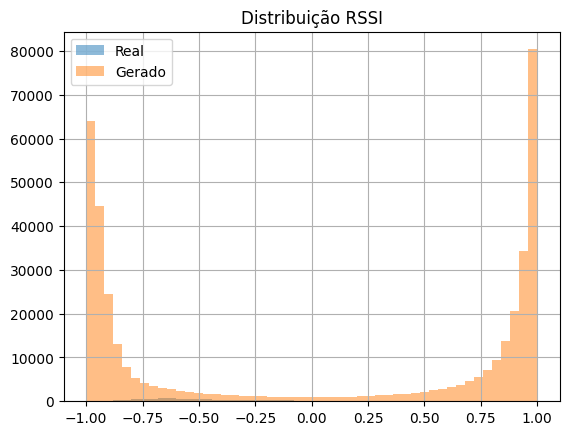

In [36]:
## 7. Estatísticas e Comparações
print("Média real:", np.mean(real_rssi_data))
print("Média gerado:", np.mean(synthetic_rssi))
print("Desvio real:", np.std(real_rssi_data))
print("Desvio gerado:", np.std(synthetic_rssi))

plt.hist(real_rssi_data.flatten(), bins=50, alpha=0.5, label="Real")
plt.hist(synthetic_rssi.flatten(), bins=50, alpha=0.5, label="Gerado")
plt.title("Distribuição RSSI")
plt.legend()
plt.grid(True)
plt.savefig("comparacao_distribuicao.png")
plt.show()


In [37]:
## 8. Salvamento dos Modelos
generator.save("generator.keras")
discriminator.save("discriminator.keras")

---
# Etapa 3: Pseudo-rotulação e Seleção Inteligente


In [39]:

## 1. Imports e Configurações"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import os 


In [ ]:
## 2. Carregamento dos Dados Reais e Sintéticos"
real_rssi_data = np.load(\"real_rssi.npy\")  # ou carregue a partir da memória se aplicável
real_positions = np.load(\"real_positions.npy\")  # coordenadas (x, y)

    "## 3. Treinamento do Modelo DNN (RSSI → Coordenadas)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "468808c2",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "X_train, X_test, y_train, y_test = train_test_split(real_rssi_data, real_positions, test_size=0.2, random_state=42)\n",
    "\n",
    "dnn = Sequential()\n",
    "dnn.add(Dense(64, activation='relu', input_shape=(10,)))\n",
    "dnn.add(Dense(64, activation='relu'))\n",
    "dnn.add(Dense(2))  # saída (x, y)\n",
    "dnn.compile(optimizer=Adam(0.001), loss='mse')\n",
    "\n",
    "history = dnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)\n"
   ]
  },
  {
   "cell_type": "markdown",
   "id": "e66d91cb",
   "metadata": {},
   "source": [


    "## 4. Avaliação do Modelo"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "fd65cf71",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "preds = dnn.predict(X_test)\n",
    "mse = mean_squared_error(y_test, preds)\n",
    "print(\"MSE:\", mse)\n",
    "\n",
    "plt.plot(history.history['loss'], label='Train Loss')\n",
    "plt.plot(history.history['val_loss'], label='Val Loss')\n",
    "plt.legend()\n",
    "plt.title(\"Treinamento da DNN\")\n",
    "plt.xlabel(\"Épocas\")\n",
    "plt.ylabel(\"MSE\")\n",
    "plt.grid(True)\n",
    "plt.savefig(\"dnn_loss.png\")\n",
    "plt.show()\n"
   ]
  },
  {
   "cell_type": "markdown",
   "id": "bbb316c9",
   "metadata": {},
   "source": [


    "## 5. Aplicação de Pseudo-rotulação nos Dados Sintéticos"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "9ffd4d08",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "pseudo_labels = dnn.predict(synthetic_rssi)\n",
    "np.save(\"pseudo_labels.npy\", pseudo_labels)\n"
   ]
  },
  {
   "cell_type": "markdown",
   "id": "e495987b",
   "metadata": {},
   "source": [


    "## 6. Divisão do Ambiente em Zonas (1m²)"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "ca51156d",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "zone_map = {}\n",
    "for i, coord in enumerate(pseudo_labels):\n",
    "    x, y = int(coord[0]), int(coord[1])\n",
    "    if 0 <= x < 20 and 0 <= y < 20:\n",
    "        zone_id = (y * 20) + x\n",
    "        if zone_id not in zone_map:\n",
    "            zone_map[zone_id] = []\n",
    "        zone_map[zone_id].append(i)\n",
    "\n",
    "# Cobertura por zona\n",
    "zone_counts = {z: len(v) for z, v in zone_map.items()}\n",
    "plt.bar(zone_counts.keys(), zone_counts.values())\n",
    "plt.title(\"Cobertura por Zona\")\n",
    "plt.xlabel(\"Zona ID\")\n",
    "plt.ylabel(\"Nº de Vetores\")\n",
    "plt.grid(True)\n",
    "plt.savefig(\"cobertura_zonas.png\")\n",
    "plt.show()\n"
   ]
  },
  {
   "cell_type": "markdown",
   "id": "3e3e3bd4",
   "metadata": {},
   "source": [


    "## 7. Avaliação de Confiança pelo Discriminador"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "5540944e",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "from tensorflow.keras.models import load_model\n",
    "discriminator = load_model(\"discriminator.keras\")\n",
    "\n",
    "scores = discriminator.predict(synthetic_rssi, verbose=0)\n",
    "np.save(\"scores_discriminator.npy\", scores)\n",
    "\n",
    "plt.hist(scores, bins=50)\n",
    "plt.title(\"Distribuição de Confiança dos Dados Sintéticos\")\n",
    "plt.xlabel(\"Confiança (D(x))\")\n",
    "plt.ylabel(\"Frequência\")\n",
    "plt.grid(True)\n",
    "plt.savefig(\"confidencias_discriminador.png\")\n",
    "plt.show()\n"
   ]
  },
  {
   "cell_type": "markdown",
   "id": "bf6444ca",
   "metadata": {},
   "source": [


    "## 8. Seleção dos Dados Sintéticos de Alta Qualidade"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "id": "a9833825",
   "metadata": {},
   "outputs": [],
   "source": [
    "\n",
    "selected_idxs = []\n",
    "\n",
    "for zone_id, indices in zone_map.items():\n",
    "    if len(indices) >= 5:  # Critério 1: cobertura mínima\n",
    "        for i in indices:\n",
    "            if scores[i] > 0.7:  # Critério 2: confiança mínima\n",
    "                selected_idxs.append(i)\n",
    "\n",
    "selected_rssi = synthetic_rssi[selected_idxs]\n",
    "selected_labels = pseudo_labels[selected_idxs]\n",
    "\n",
    "np.save(\"vetores_selecionados.npy\", selected_rssi)\n",
    "np.save(\"pseudo_labels_selecionados.npy\", selected_labels)\n",
    "\n",
    "print(f\"Selecionados {len(selected_rssi)} vetores sintéticos com pseudo-rótulos.\")\n"
   ]
  }
 ],
 "metadata": {},
 "nbformat": 4,
 "nbformat_minor": 5
}